In [208]:
# Assuming `encoded_df` is the correct DataFrame
#encoded_df.to_csv("processed_data/encoded_data.pkl")

# Suppose df is your original DataFrame
#df_processed = df_processed.copy()  # After cleaning, before encoding
#encoded_df = pd.read_csv('processed_data/cleaned_data.csv', index=False)

# Load the encoded dataframe from pickle
#encoded_df = pd.read_pickle("processed_data/encoded_data.pkl")

#plt.figure(figsize=(20, 16))
#mask = np.triu(np.ones_like(encoded_df.corr(), dtype=bool))

#sns.heatmap(encoded_df.corr(), vmin=-1, vmax=1, mask=mask, annot=True, annot_kws={'size': 6}, linewidths=0.7)

import pandas as pd
import numpy as np
import os

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

df_cluster = pd.read_csv('processed_data/cleaned_data.csv')  # just remove index=False


In [210]:
print(df_cluster.shape)
df_cluster.head()


(1210, 48)


,Self Employed,Company Size,tech company Flag,MH Coverage,MH Coverage Awareness,MH Employer Discussion,MH Resources Provided,MH Anonymity,Medical Leave,MH Discussion Neg Impact,...,MH Diagnosed by Professional,MH Sought Professional Treatment,MH Effective Treatment Impact,MH NOT Effective Treatment Impact,Gender,Living Country,Working Country,Work Position,Remote Work,Age Group
0,0,26-100,Yes,Not eligible for coverage / N/A,No,No,No,I don't know,Very easy,No,...,Yes,0,Not applicable to me,Not applicable to me,Male,UK,UK,Back-end Developer,Sometimes,30+
1,0,6-25,Yes,No,Yes,Yes,Yes,Yes,Somewhat easy,No,...,Yes,1,Rarely,Sometimes,Male,US,US,Back-end Developer|Front-end Developer,Never,20+
2,0,6-25,Yes,No,No,No,No,I don't know,Neither easy nor difficult,Maybe,...,No,1,Not applicable to me,Not applicable to me,Male,UK,UK,Back-end Developer,Always,30+
3,1,26-100,No,Yes,No,No,No,I don't know,Somewhat easy,Maybe,...,Yes,1,Sometimes,Sometimes,Male,UK,UK,Supervisor/Team Lead,Sometimes,40+
4,0,6-25,Yes,Yes,Yes,No,No,No,Neither easy nor difficult,Yes,...,Yes,1,Sometimes,Sometimes,Female,US,US,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes,40+


In [211]:
ohe = OneHotEncoder(sparse_output=False)  # drop='first' avoids multicollinearity

ohe = pd.DataFrame(ohe.fit_transform(df_cluster[categorical_renamed]),
                            columns=ohe.get_feature_names_out(categorical_renamed))

# Drop original categorical columns and concatenate OHE features
#df_processed= pd.concat([df_processed.drop(columns=categorical_renamed), ohe], axis=1)


In [212]:
print(df_cluster.columns)

Index(['Self Employed', 'Company Size', 'tech company Flag', 'MH Coverage',
       'MH Coverage Awareness', 'MH Employer Discussion',
       'MH Resources Provided', 'MH Anonymity', 'Medical Leave',
       'MH Discussion Neg Impact', 'PH Discussion Neg Impact',
       'MH Discussion Coworkers', 'MH Discussion Supervisor(s)',
       'MH vs PH Employer', 'MH Consequence Coworkers', 'Previous Employers',
       'Previous MH Benefits', 'Previous MH Awareness',
       'Previous MH Discussion', 'Previous MH Resources Provided',
       'Previous MH Anonymity', 'Previous MH Discussion Neg Impact',
       'Previous PH Discussion Neg Impact', 'Previous MH Discussion Coworkers',
       'Previous MH Discussion Supervisor(s)', 'Previous MH vs PH',
       'Previous MH Coworkers Reveal Neg', 'PH In Interview',
       'Why/ Why Not_ph', 'MH In Interview', 'Why/Why Not_mh',
       'MH Bad Impact on Career', 'MH Neg View of team members/Coworkers',
       'MH Sharing with Family/Friends', 'MH Bad Respon

In [213]:
df_cluster.head()

,Self Employed,Company Size,tech company Flag,MH Coverage,MH Coverage Awareness,MH Employer Discussion,MH Resources Provided,MH Anonymity,Medical Leave,MH Discussion Neg Impact,...,MH Diagnosed by Professional,MH Sought Professional Treatment,MH Effective Treatment Impact,MH NOT Effective Treatment Impact,Gender,Living Country,Working Country,Work Position,Remote Work,Age Group
0,0,26-100,Yes,Not eligible for coverage / N/A,No,No,No,I don't know,Very easy,No,...,Yes,0,Not applicable to me,Not applicable to me,Male,UK,UK,Back-end Developer,Sometimes,30+
1,0,6-25,Yes,No,Yes,Yes,Yes,Yes,Somewhat easy,No,...,Yes,1,Rarely,Sometimes,Male,US,US,Back-end Developer|Front-end Developer,Never,20+
2,0,6-25,Yes,No,No,No,No,I don't know,Neither easy nor difficult,Maybe,...,No,1,Not applicable to me,Not applicable to me,Male,UK,UK,Back-end Developer,Always,30+
3,1,26-100,No,Yes,No,No,No,I don't know,Somewhat easy,Maybe,...,Yes,1,Sometimes,Sometimes,Male,UK,UK,Supervisor/Team Lead,Sometimes,40+
4,0,6-25,Yes,Yes,Yes,No,No,No,Neither easy nor difficult,Yes,...,Yes,1,Sometimes,Sometimes,Female,US,US,Executive Leadership|Supervisor/Team Lead|Dev ...,Sometimes,40+


In [214]:
#encoded_df.to_csv('processed_data/cleaned_data.csv', index=False)
from sklearn.preprocessing import LabelEncoder
#encoded_df = encoded_df.copy()

le = LabelEncoder()

for column in df_cluster.columns:
    if df_cluster[column].dtype == 'object':
        df_cluster[column] = le.fit_transform(df_cluster[column].astype(str))

df_cluster.head()

,Self Employed,Company Size,tech company Flag,MH Coverage,MH Coverage Awareness,MH Employer Discussion,MH Resources Provided,MH Anonymity,Medical Leave,MH Discussion Neg Impact,...,MH Diagnosed by Professional,MH Sought Professional Treatment,MH Effective Treatment Impact,MH NOT Effective Treatment Impact,Gender,Living Country,Working Country,Work Position,Remote Work,Age Group
0,0,2,1,2,1,1,1,0,5,1,...,1,0,1,1,1,4,4,0,2,1
1,0,4,1,1,2,2,2,2,3,1,...,1,1,3,4,1,5,5,8,1,0
2,0,4,1,1,1,1,1,0,1,0,...,0,1,1,1,1,4,4,0,0,1
3,1,2,0,3,1,1,1,0,3,0,...,1,1,4,4,1,4,4,174,2,2
4,0,4,1,3,2,1,1,1,1,2,...,1,1,4,4,0,5,5,74,2,2


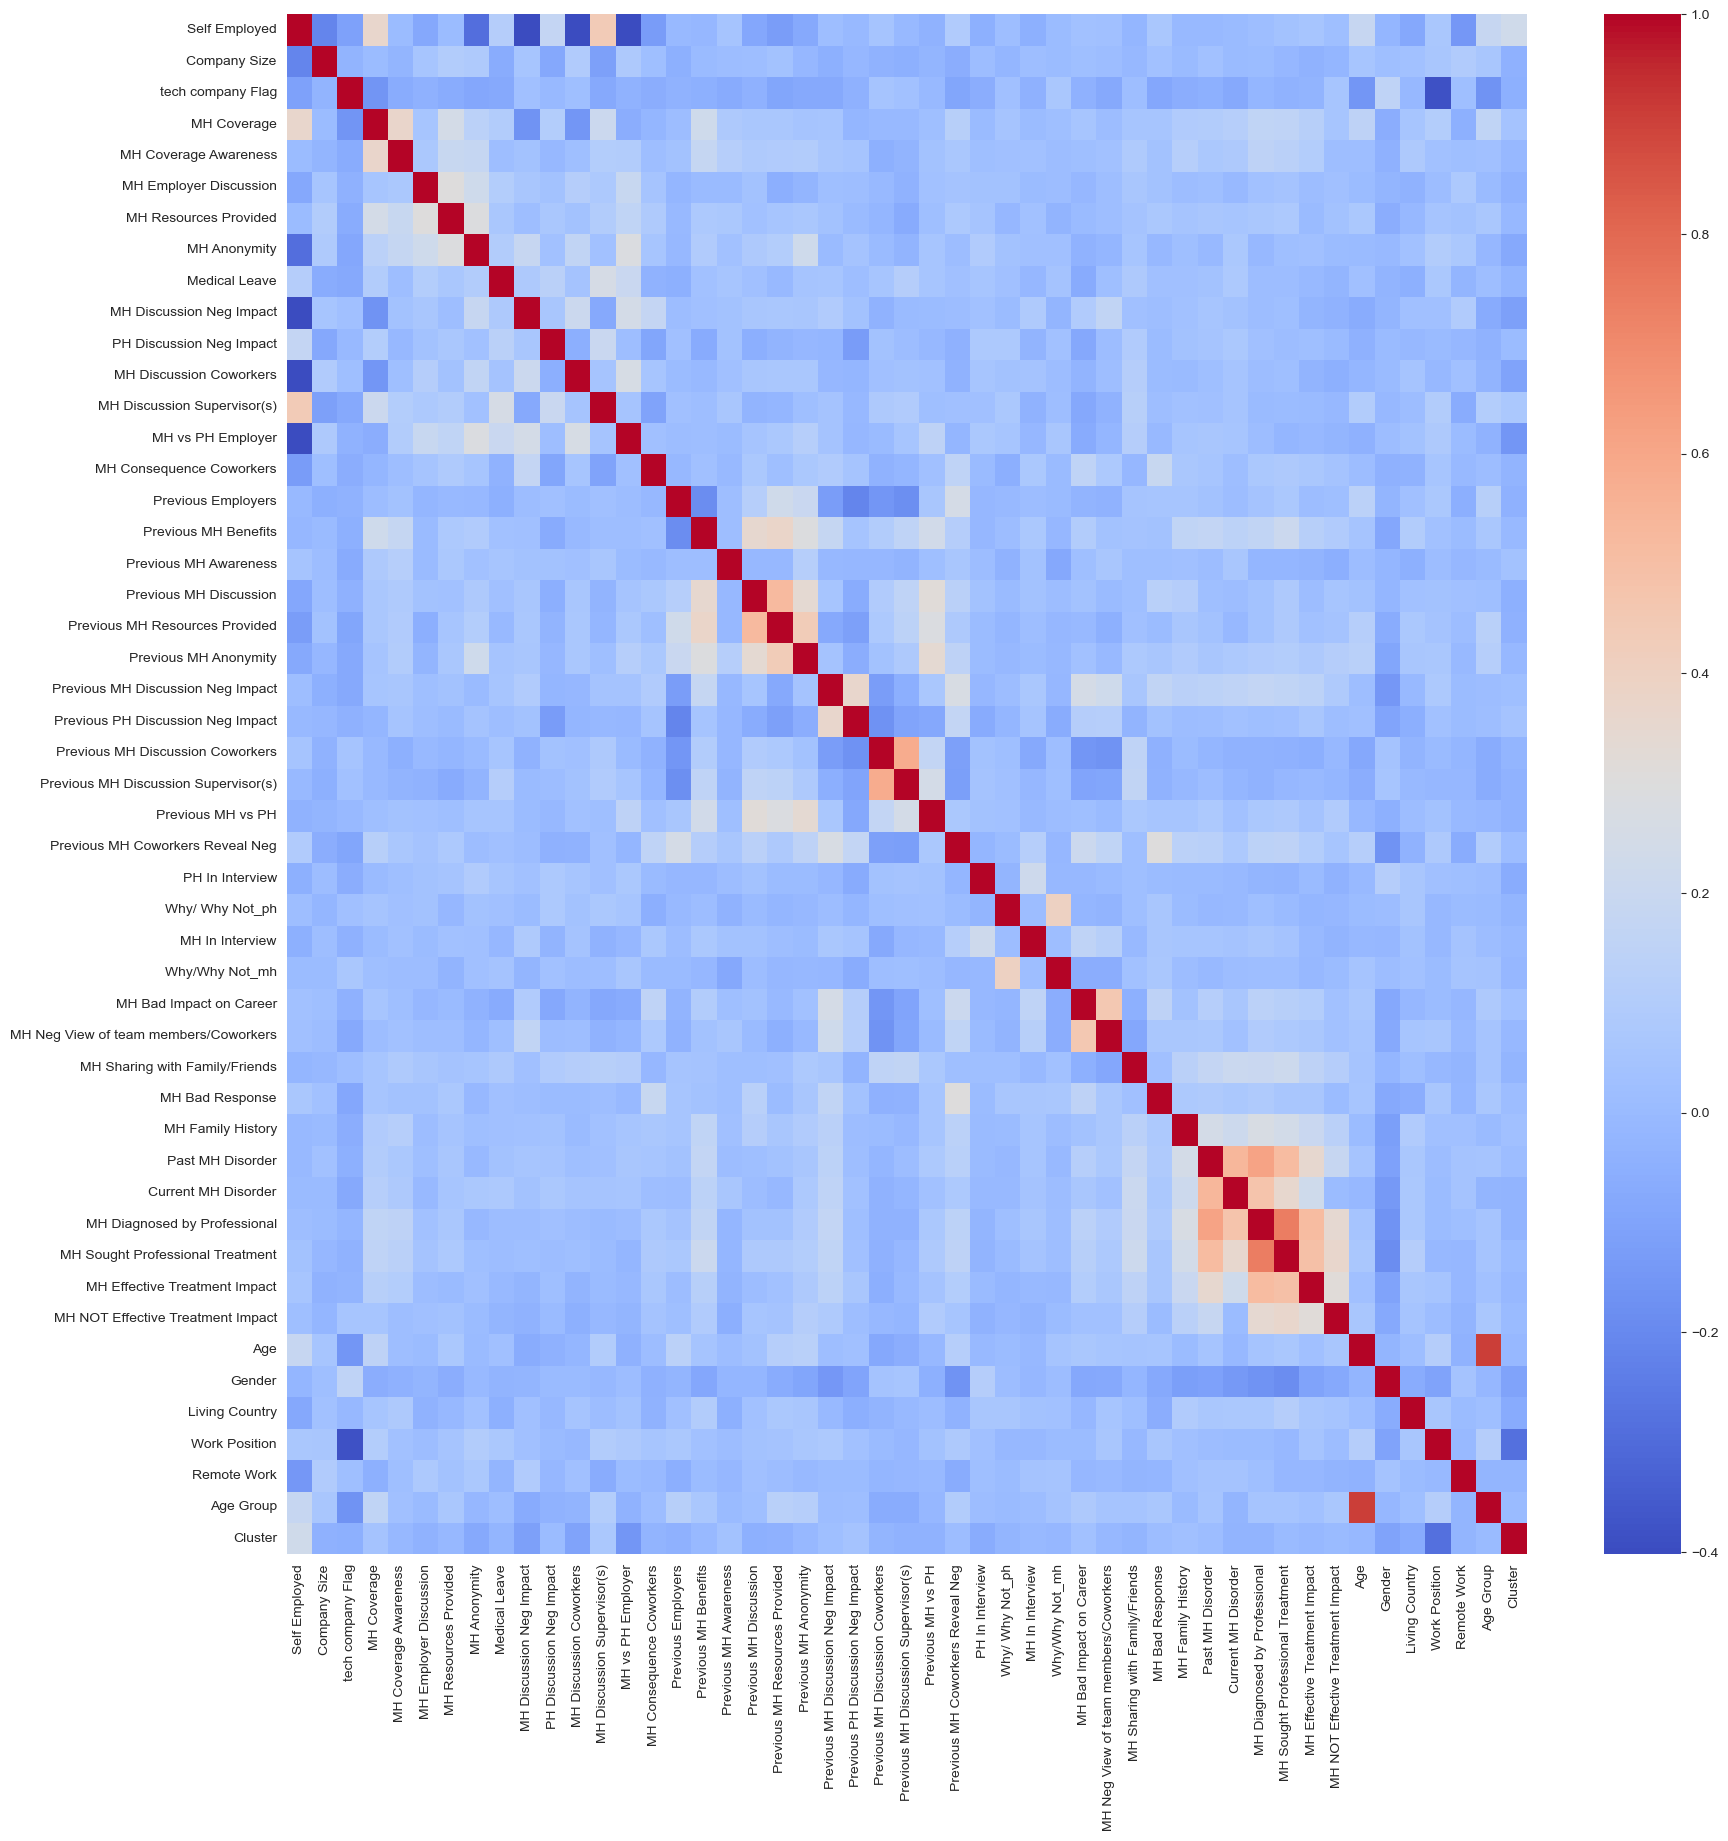

In [215]:
correlation_matrix = df_processed.corr()

plt.figure(figsize=(20, 20))

# Heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', cbar=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [216]:

columns_to_drop = df_cluster.filter(regex='Working Country').columns.to_list() # dropping country_work columns
df_cluster.drop(columns=columns_to_drop, inplace=True)
df_cluster.shape

(1210, 47)

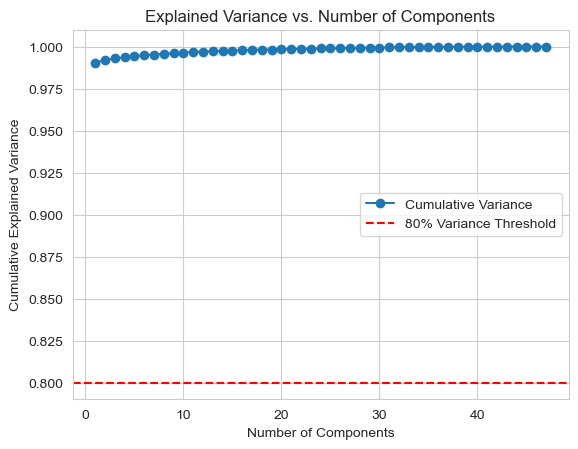

In [217]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
pca.fit(df_cluster)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Variance Threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.legend()
plt.show()


In [218]:
pca = PCA(n_components=48, random_state=1)  # Retain 90% of the variance and choose 60 most important features
data_pca = pca.fit_transform(df_processed)

pca_columns = [f'PC{i+1}' for i in range(data_pca.shape[1])]
df_pca = pd.DataFrame(data_pca, columns=pca_columns)

# Check explained variance ratio
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance)

# Step 4: Add PCA columns back to the original dataset
df_transformed = pd.concat([df_processed.reset_index(drop=True), df_pca], axis=1)

Explained Variance Ratio: [9.76642828e-01 1.36723833e-02 1.89595670e-03 8.10865699e-04
 7.14640543e-04 6.25584132e-04 4.91394984e-04 4.57183119e-04
 3.94048727e-04 3.67354224e-04 3.41047117e-04 3.23429518e-04
 2.30874221e-04 2.22621197e-04 2.10038311e-04 1.94569093e-04
 1.89846711e-04 1.70862992e-04 1.53005531e-04 1.41513695e-04
 1.35949261e-04 1.32650573e-04 1.23855215e-04 1.15869638e-04
 1.01937201e-04 1.00363827e-04 9.23107156e-05 8.96449781e-05
 8.52891641e-05 7.79848697e-05 7.31807268e-05 7.15247713e-05
 5.95823614e-05 5.56690498e-05 5.05494729e-05 4.91011799e-05
 4.47253577e-05 3.81517703e-05 3.67000236e-05 3.29573151e-05
 3.17807796e-05 2.96804333e-05 2.86022337e-05 2.63926363e-05
 2.18451664e-05 1.24735951e-05 1.14357350e-05 1.08544095e-05]


k=2, silhouette_score=0.6104
k=3, silhouette_score=0.5722
k=4, silhouette_score=0.5528
k=5, silhouette_score=0.5382
k=6, silhouette_score=0.5156
k=7, silhouette_score=0.5011
k=8, silhouette_score=0.4665
k=9, silhouette_score=0.3875
k=10, silhouette_score=0.3886
k=11, silhouette_score=0.3750
k=12, silhouette_score=0.3647


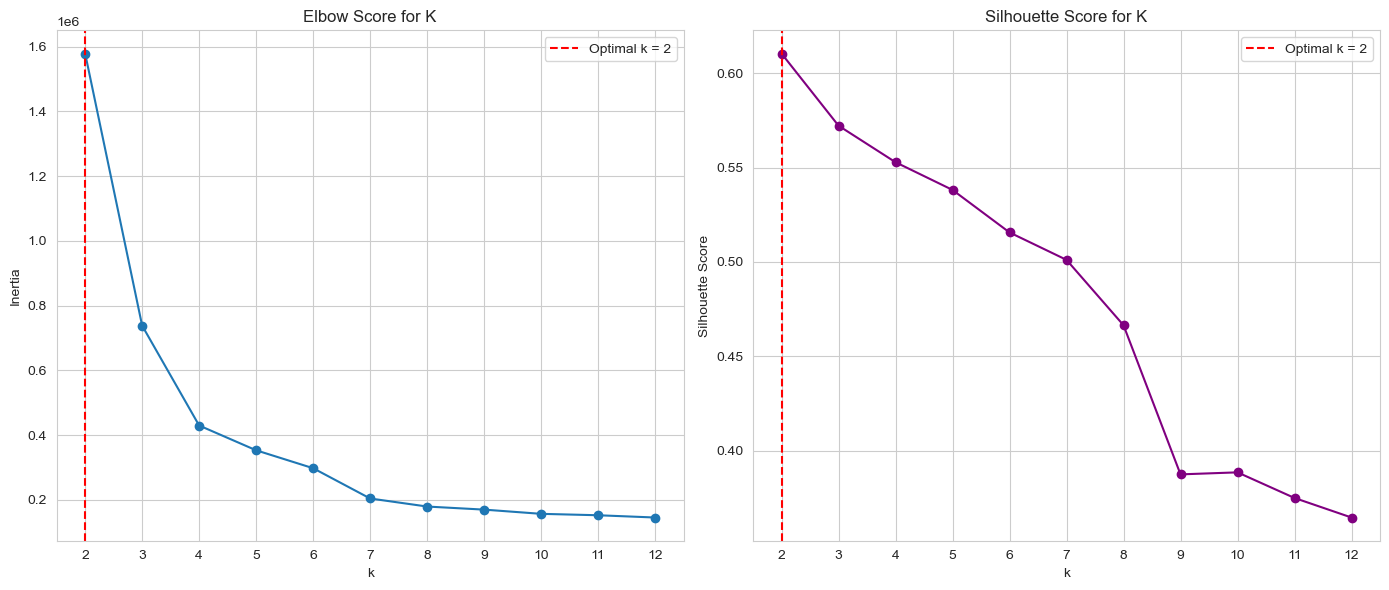

In [219]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

inertia = []
kmeans_value = range(2, 13)  # for iterating k in range of 2 to 12
silhouette_scores = []

for k in kmeans_value:
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=1)
    clusters = kmeans.fit_predict(data_pca)
    silhouette = silhouette_score(data_pca, clusters)
    print(f"k={k}, silhouette_score={silhouette:.4f}")  # <-- Add this line
    silhouette_scores.append(silhouette)
    inertia.append(kmeans.inertia_)


# Find optimal k based on max silhouette score
optimal_k = kmeans_value[np.argmax(silhouette_scores)]

plt.figure(figsize=(14, 6))

# Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(kmeans_value, inertia, marker='o')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title("Elbow Score for K")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.xticks(kmeans_value)
plt.grid(True)
plt.legend()

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(kmeans_value, silhouette_scores, color='purple', marker='o')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.title("Silhouette Score for K")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.xticks(kmeans_value)
plt.grid(True)
plt.legend()

# Save the plot
plt.tight_layout()
output_dir = "images"
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, "kmeans_elbow_silhouette.png")
plt.savefig(plot_path)

plt.tight_layout()
plt.show()

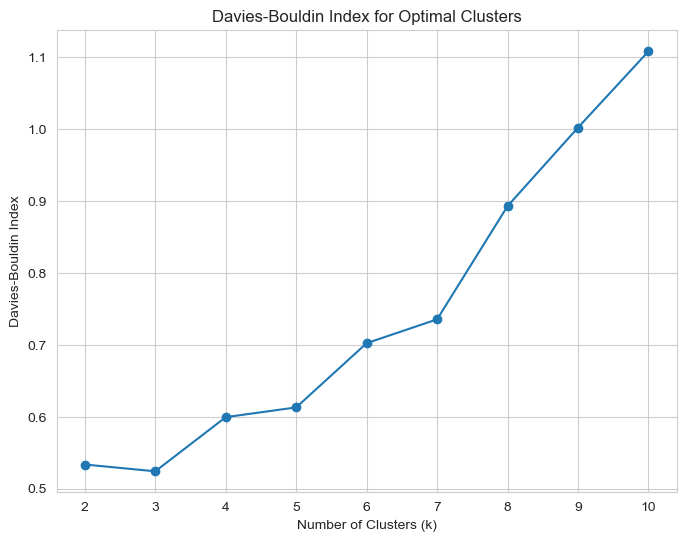

In [220]:
k_range = range(2, 11)
db_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_pca)
    db_scores.append(davies_bouldin_score(data_pca, labels))

# Plot Davies-Bouldin Index
plt.figure(figsize=(8, 6))
plt.plot(k_range, db_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index for Optimal Clusters')

# Save plot to 'images' directory
output_dir = "images"
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, "renamed_working_living_country_distribution.png")
plt.savefig(plot_path)

plt.show()

In [222]:
import joblib

# Save the fitted OneHotEncoder
joblib.dump(ohe, 'encoders/ohe_encoder.joblib')

['encoders/ohe_encoder.joblib']

In [223]:
kmeans = KMeans(n_clusters=3, max_iter=500, random_state=1)
label = kmeans.fit_predict(data_pca)


Top distinguishing features by cluster:

Cluster 0 top features:
Work Position                     187.702381
Living Country                      4.432540
Why/Why Not_mh                      3.916667
Why/ Why Not_ph                     3.853175
MH Sharing with Family/Friends      3.345238
Name: 0, dtype: float64

Cluster 1 top features:
Work Position                     14.247012
Living Country                     4.223108
Why/Why Not_mh                     3.918327
Why/ Why Not_ph                    3.864542
MH Sharing with Family/Friends     3.370518
Name: 1, dtype: float64

Cluster 2 top features:
Work Position                     101.526316
Living Country                      4.164474
Why/Why Not_mh                      3.815789
Why/ Why Not_ph                     3.695175
MH Sharing with Family/Friends      3.250000
Name: 2, dtype: float64


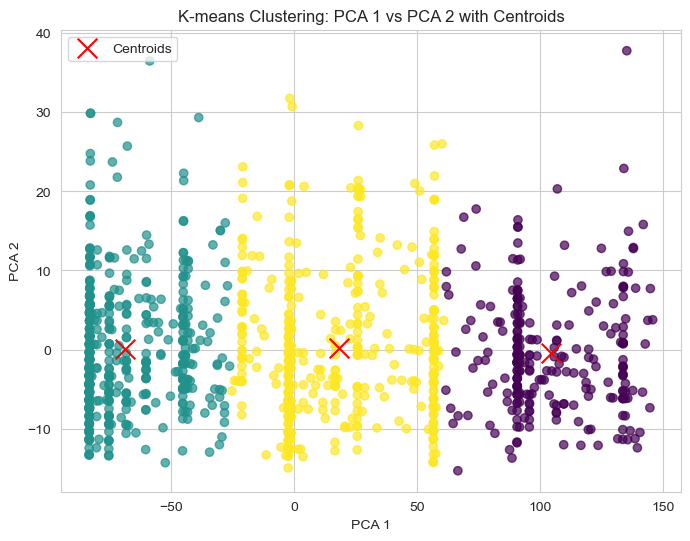

In [231]:
import os
os.makedirs('outputs', exist_ok=True)  # ✅ Create folder if it doesn't exist

centroids = kmeans.cluster_centers_
df_pca['Cluster'] = label
df_cluster['Cluster'] = label

# Cluster interpretation block
cluster_summary = df_cluster.groupby('Cluster').mean(numeric_only=True)
cluster_summary = cluster_summary.T
cluster_summary.to_csv('outputs/cluster_feature_summary.csv')

print("\nTop distinguishing features by cluster:")
for cluster_num in cluster_summary.columns:
    print(f"\nCluster {cluster_num} top features:")
    print(cluster_summary[cluster_num].sort_values(ascending=False).head(5))

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Cluster'], cmap='viridis', alpha=0.7)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title('K-means Clustering: PCA 1 vs PCA 2 with Centroids')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()


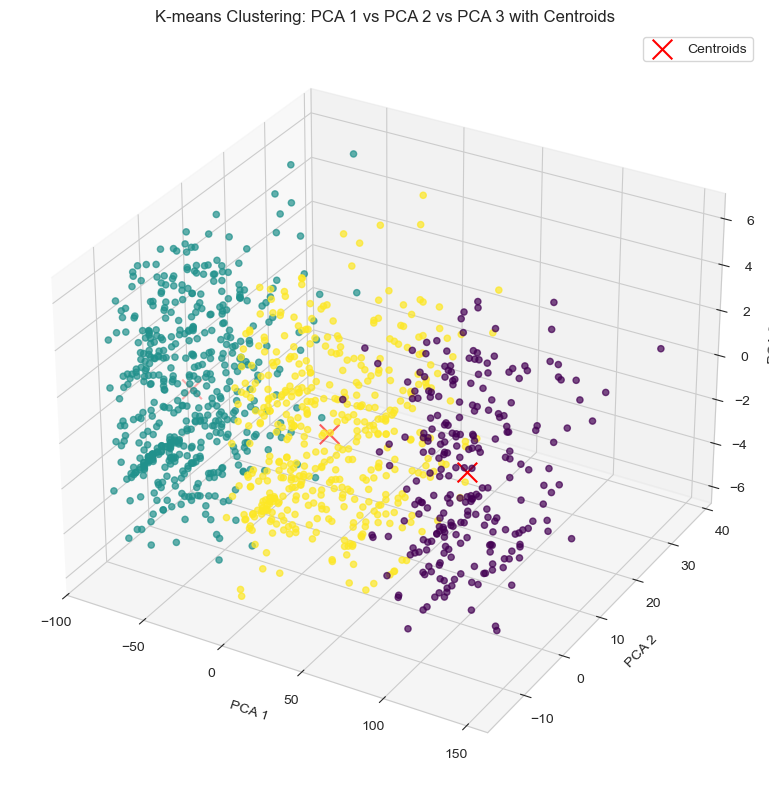

In [225]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
from sklearn.decomposition import PCA
import pandas as pd

# Create DataFrame from PCA results
df_pca = pd.DataFrame(data_pca[:, :3], columns=['PC1', 'PC2', 'PC3'])
df_pca['Cluster'] = label
df_cluster['Cluster'] = label  # Optional if you want to keep original + cluster info

# Get centroids
centroids = kmeans.cluster_centers_

# 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for clusters
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
                     c=df_pca['Cluster'], cmap='viridis', alpha=0.7)

# Plot centroids
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           c='red', s=200, marker='x', label='Centroids')

# Labels and legend
ax.set_title('K-means Clustering: PCA 1 vs PCA 2 vs PCA 3 with Centroids')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
ax.legend()

plt.tight_layout()
plt.show()

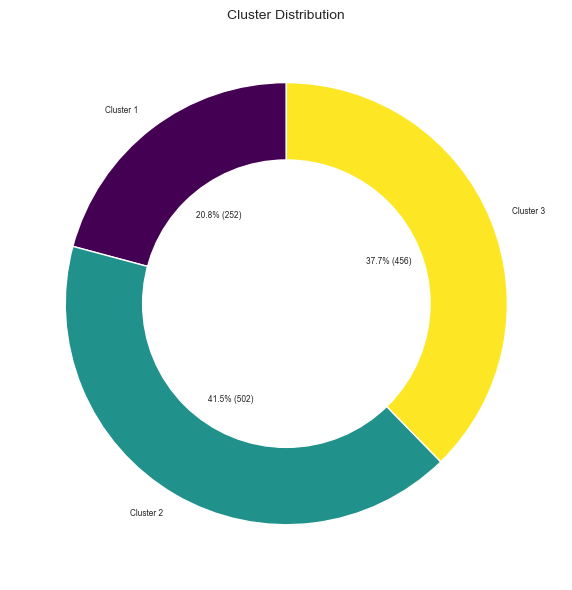

In [226]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Count the number of samples in each cluster
sizes = df_cluster['Cluster'].value_counts().sort_index().tolist()
cl_labels = [f'Cluster {i + 1}' for i in range(len(sizes))]

# Function to display percent and count
def func(val):
    a = int(np.round(val / 100. * sum(sizes)))
    return f'{round(val, 1)}% ({a})'

# Colors
colors = cm.viridis(np.linspace(0, 1, len(sizes)))

# Plot
plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=cl_labels,
    autopct=func,
    startangle=90,
    pctdistance=0.5,
    colors=colors,
    textprops={'fontsize': 6}
)

# Donut hole
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Adjust label font sizes
for text in texts:
    text.set_fontsize(6)

plt.title("Cluster Distribution", fontsize=10)
plt.tight_layout()

# Save and show
output_dir = "images"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "cluster_distribution_donut.png"))
plt.show()


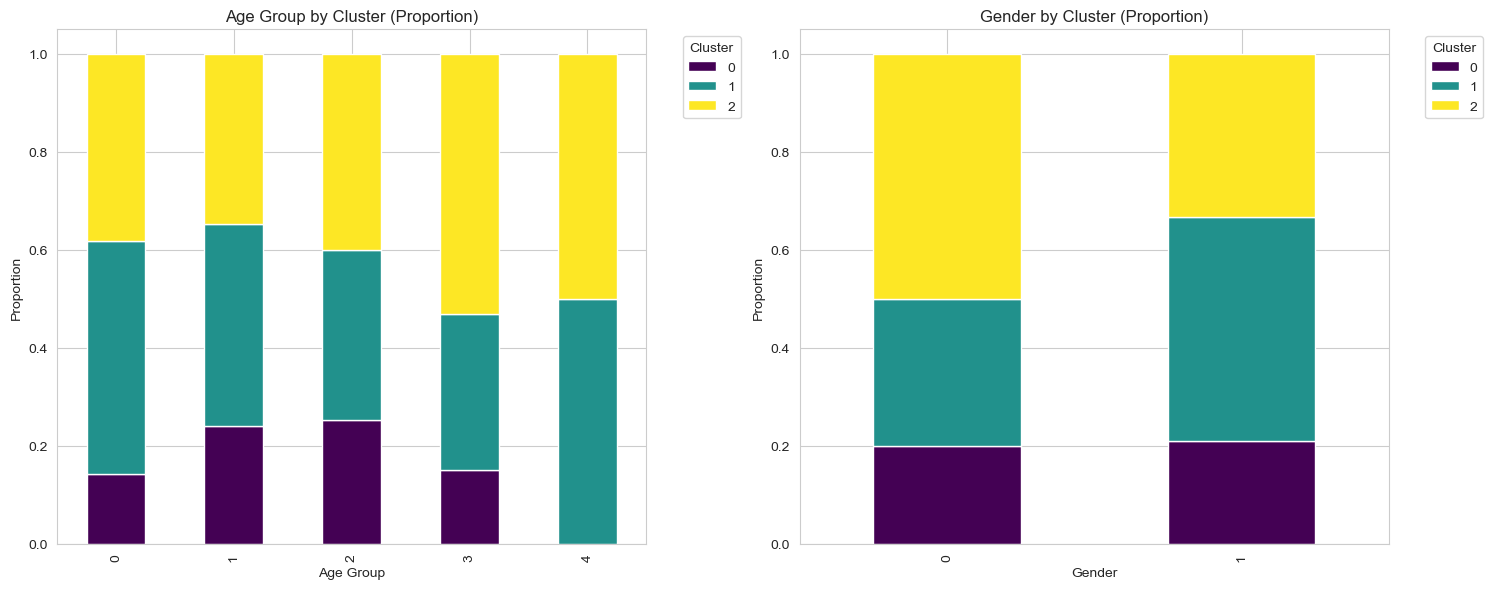

In [229]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Normalize counts to show proportions
def plot_cluster_proportions(df, col, ax):
    cluster_counts = pd.crosstab(df[col], df["Cluster"], normalize='index')
    cluster_counts.plot(kind='bar', stacked=True, ax=ax, colormap='viridis')
    ax.set_title(f"{col} by Cluster (Proportion)")
    ax.set_ylabel("Proportion")
    ax.set_xlabel(col)
    ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_cluster_proportions(df_cluster, 'Age Group', ax[0])
plot_cluster_proportions(df_cluster, 'Gender', ax[1])

plt.tight_layout()
plt.show()

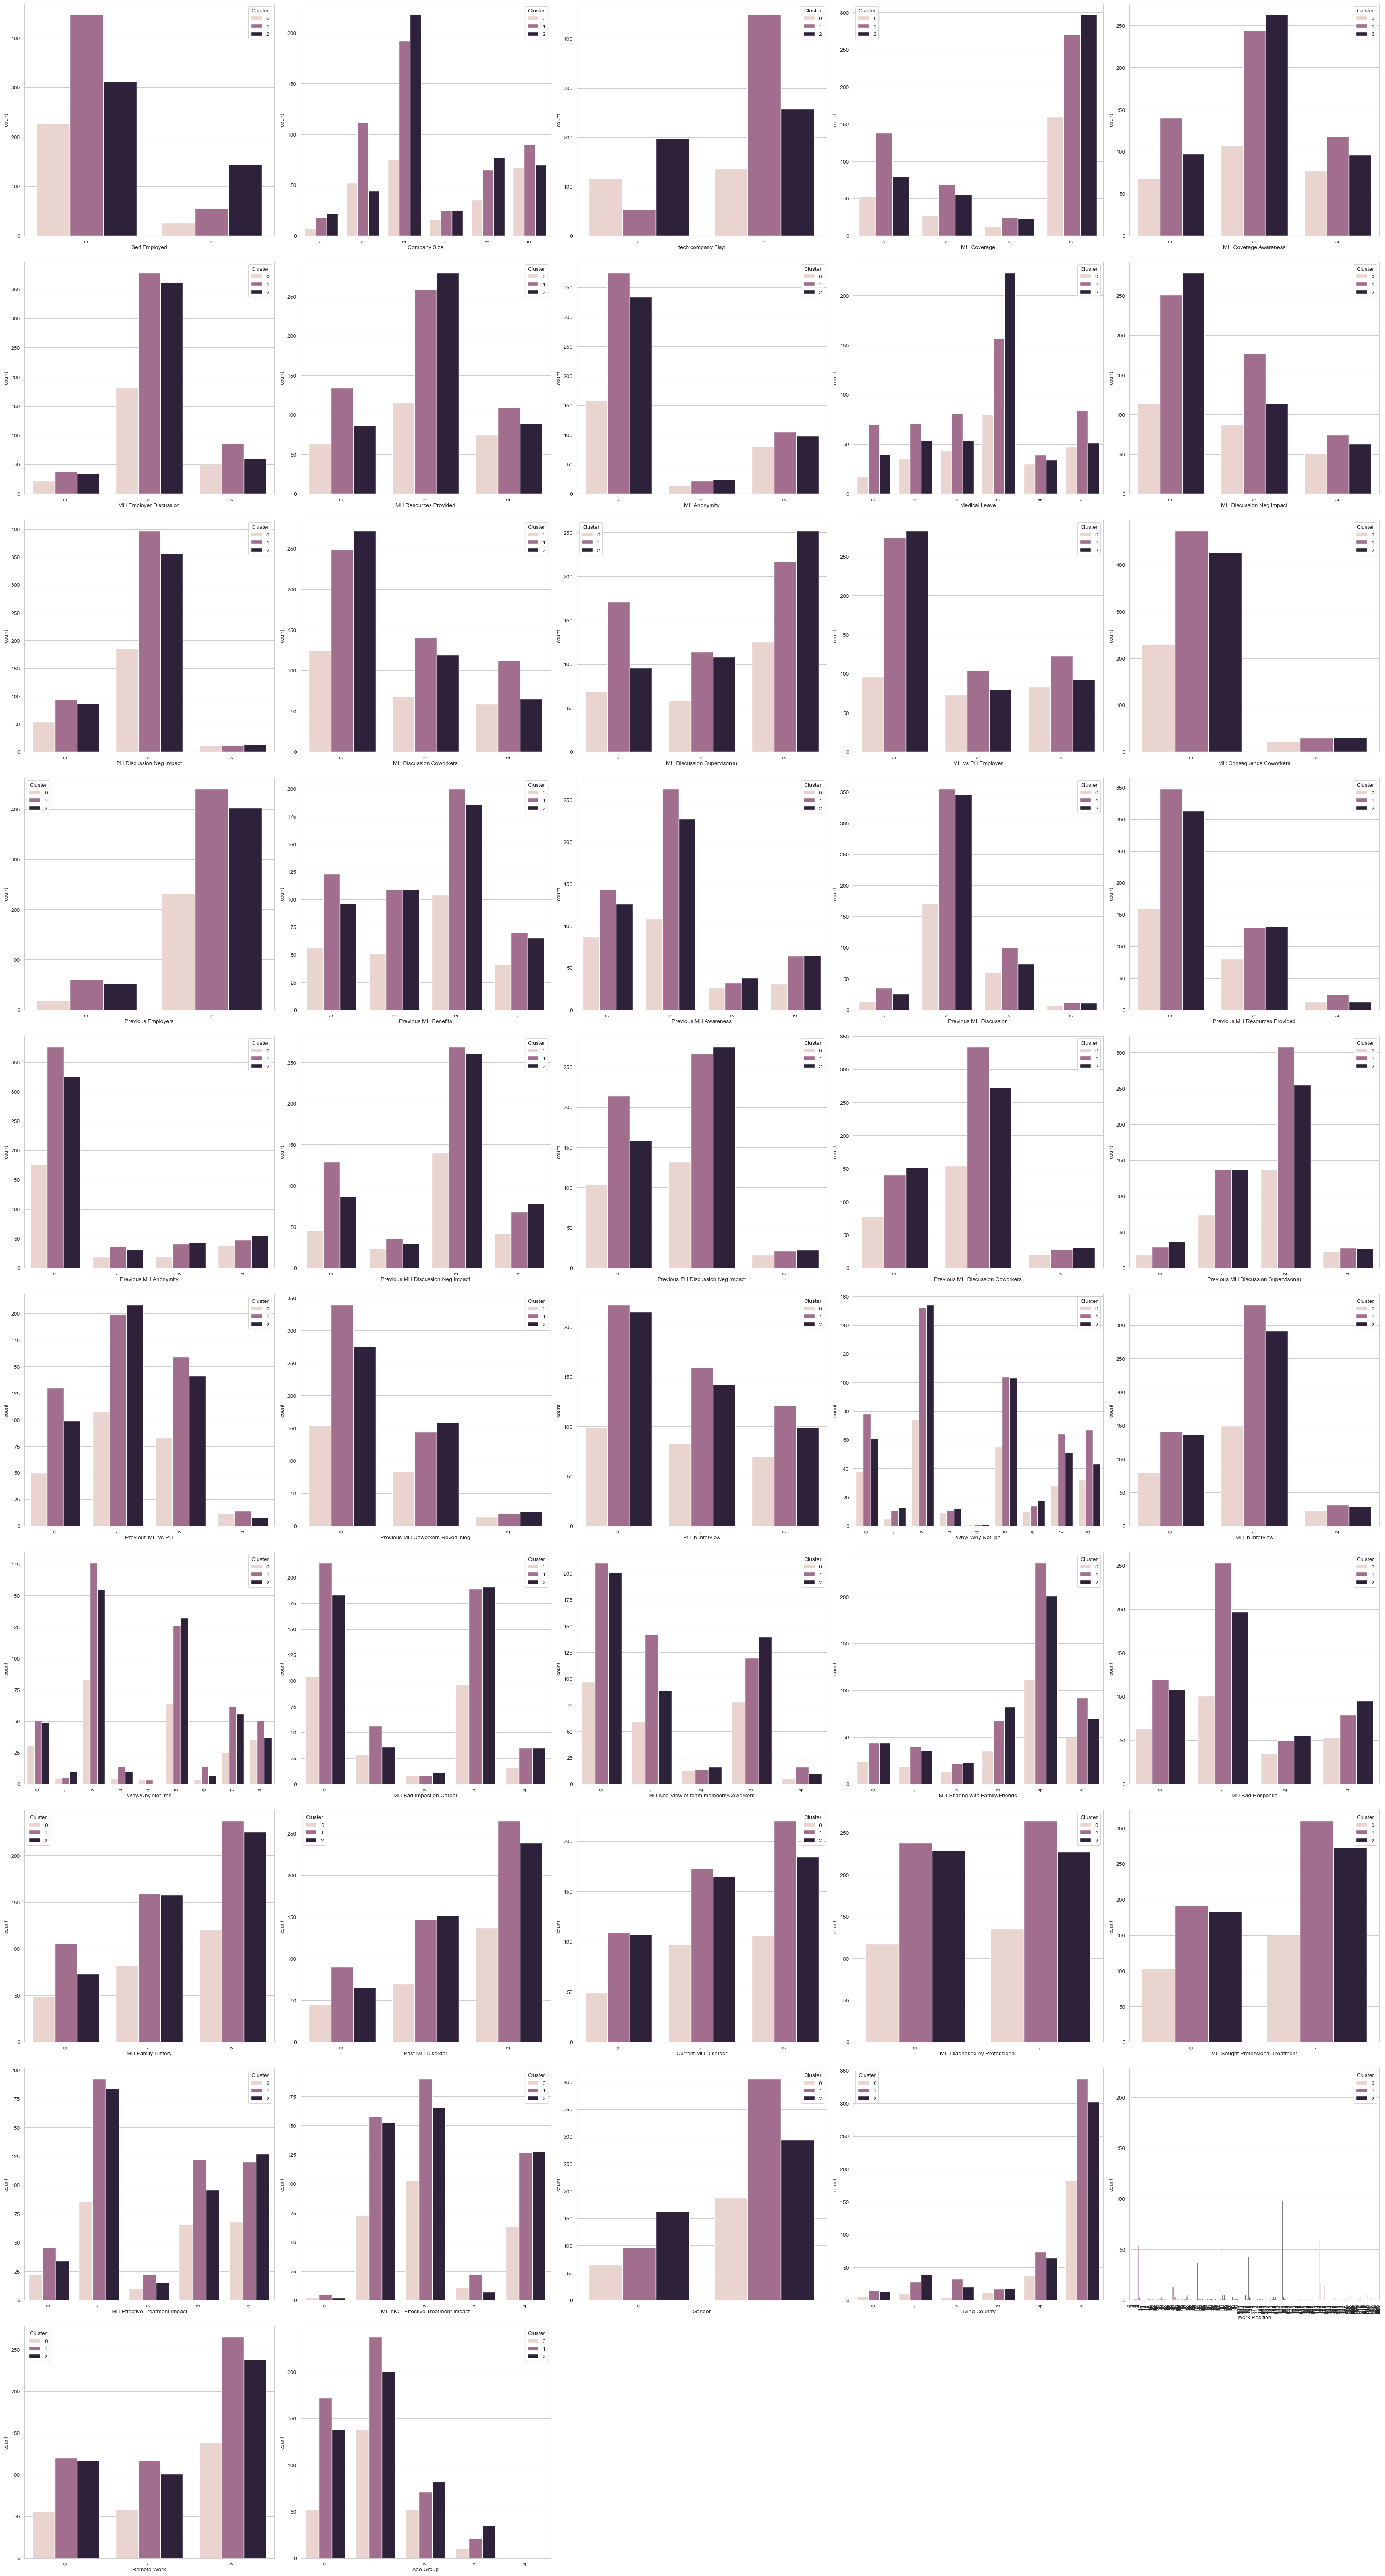

In [233]:
plt.figure(figsize=(35, 65))

for i, column in enumerate(df_cluster.columns):
    if column != 'Cluster':  # <- corrected here too
        plt.subplot(10, 5, i + 1)
        sns.countplot(data=df_cluster, x=column, hue='Cluster')  # <- fixed
        plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('outputs/cluster-bar-chart.png')  # Ensure 'outputs/' folder exists
plt.show()


In [ ]:
df_pca.head()

In [ ]:
encoded_df.to_pickle('processed_data/encoded_data.pkl')  # save to pickle

# then later load it by
encoded_df = pd.read_pickle('processed_data/encoded_data.pkl')

In [ ]:
from prince import MCA
mca = MCA(n_components=85, n_iter=50, copy=True, check_input=True, random_state=42, one_hot=True)
mca_components = mca.fit(encoded_df)

mca_components.eigenvalues_summary #

In [ ]:
mca_coordinates = mca.transform(encoded_df)
mca_coordinates

In [ ]:
features_names = mca_components.column_contributions_.mean(axis=1).sort_values(ascending=False).keys()
features_values = list(mca_components.column_contributions_.mean(axis=1).sort_values(ascending=False))

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="darkgrid")


# create a k-Means model an Elbow-Visualizer
model = KMeans(init="k-means++", max_iter=200)

visualizer = KElbowVisualizer(model, timings=False, k=8)
# fit the visualizer and show the plot
plt.figure(figsize=(10, 5))
visualizer.fit(mca_coordinates)
visualizer.show()


In [ ]:
# clustering
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto',init='k-means++', max_iter=200)
clustering = kmeans.fit_predict(mca_coordinates)


# extract centroids of clusters into a dataframe
centers = kmeans.cluster_centers_

# extract cluster labels
labels = kmeans.labels_

In [ ]:
cluster_characteristics = []
sizes = []

for i in range(n_clusters):
    cluster_data = mca_coordinates[labels == i]
    cluster_size = len(cluster_data)
    cluster_center = centers[i]
    avg_distance = np.mean(np.linalg.norm(cluster_data - cluster_center, axis=1))
    cluster_characteristics.append({
        "Cluster": i + 1,
        "Size": cluster_size,
        "Avg Distance": avg_distance,
    })
    sizes.append(cluster_size)

cluster_characteristics

In [ ]:

from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Inertia
inertia_score = kmeans.inertia_
print("Inertia:", inertia_score)

# Silhouette Score
silhouette_avg = silhouette_score(mca_coordinates, labels)
print("Silhouette Avg:", round(silhouette_avg, 4))

# Calinski Harabasz Score
cal_score = calinski_harabasz_score(mca_coordinates, labels)
print("Calinski Harabasz Score:", round(cal_score, 1))

# Davies Bouldin Score
d_score = davies_bouldin_score(mca_coordinates, labels)
print("Davies Bouldin Score:", round(d_score, 2))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

# Example sizes – replace with your actual cluster sizes
# sizes = [count1, count2, ..., countN]

cl_labels = [f'Cluster {i + 1}' for i in range(len(sizes))]

def func(val):
    a = int(np.round(val / 100. * sum(sizes)))
    return f'{round(val, 1)}% ({a})'

colors = cm.viridis(np.linspace(0, 1, len(sizes)))

plt.figure(figsize=(6, 6))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=cl_labels,
    autopct=func,
    startangle=90,
    pctdistance=0.5,  # Pull percentages inward
    colors=colors,
    textprops={'fontsize': 6}  # Very small text
)

# Donut hole (slightly smaller for more room)
centre_circle = plt.Circle((0, 0), 0.65, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Make label text small too
for text in texts:
    text.set_fontsize(6)

plt.title("Cluster Distribution", fontsize=10)
plt.tight_layout()
plt.savefig("clusters.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import cm

# t-SNE projections
tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(mca_coordinates)

# Generate a list of colors from the viridis colormap
colors = cm.plasma(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(
        projections[labels == i][:, 0],
        projections[labels == i][:, 1],
        label=f'Cluster {i + 1}',
        color=colors[i],
        s=30  # marker size
    )

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('K-means Clustering with t-SNE')
plt.legend()
plt.tight_layout()
plt.savefig("tsne.png")
plt.show()

In [ ]:
encoded_df['Clusters'] = labels

In [ ]:
def cluster_profile(data):
    profile = {}

    for column_name in data.columns:
        if column_name != 'Clusters':
            profile[f'{column_name}'] = data[column_name].value_counts().keys()[0]

    return profile

In [ ]:
profiles = encoded_df.groupby('Clusters').apply(cluster_profile)
profiles_df = pd.DataFrame(profiles.tolist(), index=profiles.index)
profiles_df.iloc[:, :15]

In [ ]:
profiles_df.iloc[:, 15:30]

In [ ]:
plt.figure(figsize=(35, 65))
for i, column in enumerate(encoded_df.columns):
    if column != 'Clusters':
        plt.subplot(10, 5, i+1)
        sns.countplot(data=encoded_df, x=column, hue='Clusters')
        plt.xticks(rotation=90)
        plt.subplots_adjust(wspace=0.2, hspace=0.8)

plt.savefig('cluster-bar-chart.png')

In [ ]:
import os

# Create the directory named 'processed_data' if it doesn't exist
#os.makedirs('processed_data', exist_ok=True)

# Save the selected features CSV inside the 'processed_data' folder
#selected_features_df.to_csv('processed_data/selected_features.csv', index=False)
